### Imports

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import math


https://naif.jpl.nasa.gov/naif/Ancillary_Data_Production_v2.pdf

In [2]:
# https://naif.jpl.nasa.gov/naif/aboutspice.html
import spiceypy as spice

### Constants

In [3]:
DEG = np.pi / 180.0 #degrees #spice angles are in radians
MU_SUN = 1.32712440018e11  #km^3/s^2 #standard gravitational parameter of Sun

### Get Data

In [4]:
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/

def load_kernels():
    spice.furnsh("../data/naif0012.tls")      # Leap seconds - conversion of earth time to ephemeris time
    spice.furnsh("../data/de440s.bsp")        # Ephemeris data - position and velocities
    spice.furnsh("../data/pck00011.tpc")      # Planetary constants - radius, spin axes, rotation rates etc.

### Get Angle between 2 Vectors

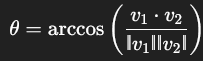

In [5]:
def get_angle_between_vectors(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        raise ValueError("One of the vectors has zero length")
    cos_theta = dot / (norm1 * norm2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.arccos(cos_theta)
    # return spice.vsep(v1, v2)

### Get Angular Distance

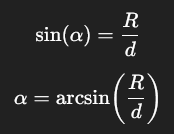

In [6]:
# Get angular radius (how big a body of given radius looks from given distance) - values clamped [0,1]
def get_angular_radius(radius_km, dist_km):
    x = max(0.0, min(1.0, radius_km / max(dist_km, 1e-9)))
    return math.asin(x)

### Get Radius

SPICE stores 3 radii (across x, y, z) - as things are not perfect spheres  
so we take a mean of the 3  

In [7]:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/IDL/icy/cspice_bodvrd.html
def get_mean_radius_km(body_name):
    radii = spice.bodvrd(body_name.upper(), "RADII", 3)[1]
    return float(np.mean(radii))

### Get State Vector

are basically a vector concatenating position and velocity of a body in 3 cartesian coordinates w.r.t. another body

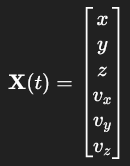

In [8]:
 def get_state_vec(targ, obs, et, ref="J2000"):
    state, lt = spice.spkgeo(targ=targ, et=et, ref=ref, obs=obs)
    return np.array(state[:3])

#### Alternate

https://orbital-mechanics.space/intro.html

https://mae-nas.eng.usu.edu/MAE_5540_Web/propulsion_systems/section2/section2.2.pdf

Mean motion (n) is the average angular speed of a body in its orbit, defined as the rate at which it sweeps out equal areas in equal times  
 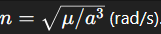  
 n = np.sqrt(mu / semi_major_ax_km**3)

Mean Anomaly (M) is the angle that a body would have moved if it were moving at a constant angular speed equal to the mean motion (n) from periapsis at epoch time to the current time. It is used in Kepler's equation to find the eccentric anomaly (E)  
   
 M = mean_anomaly_epoch + n * time_since_epoch

Eccentric Anomaly (E) is the angle that describes the position of a body in its elliptical orbit, measured from the center of the ellipse. It is used to relate the mean anomaly (M) to the true anomaly (θ) in Kepler's laws of planetary motion. Eccentric anomaly is defined such that it is related to the mean anomaly through Kepler's equation  
  
E = E - (E - e*np.sin(E) - M) / (1 - e*np.cos(E))

True Anomaly (θ) is the angle between the direction of periapsis and the current position of the body in its orbit, measured at the main focus of the ellipse where the central body is located. It is used to describe the position of a body in its elliptical orbit relative to periapsis  
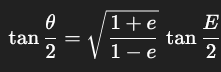  
theta = 2*np.arctan2(np.sqrt(1+eccentricity)*np.sin(E/2),np.sqrt(1-eccentricity)*np.cos(E/2))

Radius in the orbit (from focus) based on accentricity    
  
r_mag = semi_major_ax_km * (1 - eccentricity*np.cos(E))

Position Vector (orbital plane)  
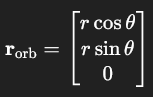  
r_orb = np.array([r_mag*np.cos(theta), r_mag*np.sin(theta), 0])

Orbital Velocity  
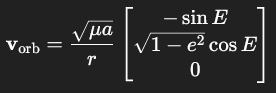  
v_orb = np.array([
    -np.sqrt(mu*semi_major_ax_km)/r_mag * np.sin(E),
     np.sqrt(mu*semi_major_ax_km)/r_mag * np.sqrt(1-e**2) * np.cos(E),
     0
])

In [9]:
def get_kepler_state_vector(semi_major_ax_km, eccentricity, inclination, ra_ascending_node, 
                            arg_periapsis, mean_anomaly_epoch, time_epoch, mu=MU_SUN):
    n = np.sqrt(mu / semi_major_ax_km**3)
    M = mean_anomaly_epoch + n * time_epoch
    
    E = M
    for _ in range(50):
        E = E - (E - e*np.sin(E) - M) / (1 - e*np.cos(E))
    theta = 2*np.arctan2(np.sqrt(1+eccentricity)*np.sin(E/2),np.sqrt(1-eccentricity)*np.cos(E/2))
    
    r_mag = semi_major_ax_km * (1 - eccentricity*np.cos(E))
    r_orb = np.array([r_mag*np.cos(theta), r_mag*np.sin(theta), 0])
    v_orb = np.array([
        -np.sqrt(mu*semi_major_ax_km)/r_mag * np.sin(E),
         np.sqrt(mu*semi_major_ax_km)/r_mag * np.sqrt(1-e**2) * np.cos(E),
         0
    ])
    
    cos_raan, sin_raan = np.cos(ra_ascending_node), np.sin(ra_ascending_node)
    cos_i, sin_i = np.cos(inclination), np.sin(inclination)
    cos_argp, sin_argp = np.cos(arg_periapsis), np.sin(arg_periapsis)

    R = np.array([
        [cos_raan*cos_argp - sin_raan*sin_argp*cos_i, -cos_raan*sin_argp - sin_raan*cos_argp*cos_i, sin_raan*sin_i],
        [sin_raan*cos_argp + cos_raan*sin_argp*cos_i, -sin_raan*sin_argp + cos_raan*cos_argp*cos_i, -cos_raan*sin_i],
        [sin_argp*sin_i,                              cos_argp*sin_i,                               cos_i]
    ])

    r = R @ r_orb
    v = R @ v_orb
    return r, v

In [10]:
# Convert degrees to radians
deg = np.pi/180
a = 149598023  # km
e = 0.0167
i = 0.00005 * deg
raan = -11.26064 * deg
argp = 102.94719 * deg
M0 = 100.46435 * deg

# Time since epoch = 0 (J2000)
dt = 0.0  

r, v = get_kepler_state_vector(semi_major_ax_km=a, eccentricity=e, inclination=i,
                                ra_ascending_node=raan, arg_periapsis=argp,mean_anomaly_epoch=M0, time_epoch=dt)
# get_kepler_state_vector(a, e, i, raan, argp, M0, dt)
print("Kepler state vector position (km):", r)
print("Kepler state vector velocity (km/s):", v)


Kepler state vector position (km): [-1.45617502e+08 -3.63748466e+07 -5.59462521e+01]
Kepler state vector velocity (km/s): [ 6.72207874e+00 -2.89154307e+01 -2.36022131e-05]


In [11]:
load_kernels()
t = datetime.fromisoformat("2025-01-01")
et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S")) 

r_spice = get_state_vec(10, 399, et)
print("SPICE state vector position (km):", r_spice)
# print("Kepler state vector velocity (km/s):", v_spice)


SPICE state vector position (km): [ 2.67327232e+07 -1.32724330e+08 -5.75347084e+07]


### Get Separation over time range

In [ ]:
def solar_moon_separation_over_range(start_date, end_date, step_hours=6):
    """Sun–Moon angular separation (as seen from Earth’s center) over time."""
    ets, seps_deg, dates = [], [], []
    t = start_date
    while t <= end_date:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        # Vectors from Earth to Sun and Moon:
        r_es = state_vec(10, 399, et)     # Sun wrt Earth
        r_em = state_vec(301, 399, et)    # Moon wrt Earth
        sep = ang(r_es, r_em) * DEG
        ets.append(et); seps_deg.append(sep); dates.append(t)
        t += timedelta(hours=step_hours)
    return np.array(ets), np.array(seps_deg), dates

### Get Eclipse Candidate

In [ ]:
def lunar_eclipse_candidates(start_date, end_date, step_hours=2, tol_deg=0.8):
    """
    Very reasonable lunar-eclipse test (umbra criterion, geocentric):
    At the Moon, compare angular radius of Earth versus Sun.
    If Moon is near the anti-solar direction of Earth and Earth’s apparent radius
    exceeds Sun’s by some margin, we flag a candidate.
    """
    dates, flags = [], []
    t = start_date

    # Body mean radii (km)
    R_earth = mean_radius_km("EARTH")
    R_sun   = mean_radius_km("SUN")

    while t <= end_date:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        # Positions wrt Moon:
        r_me = -state_vec(301, 399, et)               # Earth wrt Moon = negative of Moon wrt Earth
        r_ms =  state_vec(10, 301, et)                # Sun wrt Moon

        # Distances
        d_me = np.linalg.norm(r_me)                   # Moon->Earth
        d_ms = np.linalg.norm(r_ms)                   # Moon->Sun

        # Angular radii as seen from Moon
        alpha_E = angular_radius(R_earth, d_me)
        alpha_S = angular_radius(R_sun,   d_ms)

        # Angle between anti-solar direction and Earth direction as seen from Moon
        # Anti-solar vector at Moon is -r_ms; compare it to r_me
        theta = ang(r_me, -r_ms) * DEG

        # Heuristic: alignment within tol_deg and Earth's apparent radius >= Sun's ⇒ umbral possibility
        is_candidate = (theta < tol_deg) and (alpha_E > alpha_S)
        dates.append(t); flags.append(is_candidate)
        t += timedelta(hours=step_hours)

    # Collapse contiguous runs to date windows
    windows = []
    active = False; start = None
    for i, flag in enumerate(flags):
        if flag and not active:
            active = True; start = dates[i]
        if active and (not flag or i == len(flags)-1):
            end = dates[i] if flag else dates[i-1]
            windows.append((start, end))
            active = False
    return windows




### Get Simulation

In [ ]:
def run_sim(start="2025-01-01", stop="2025-12-31", solar_sep_threshold_deg=0.6, sep_step_hours=6):
    load_kernels()
    start_date = datetime.fromisoformat(start)
    end_date   = datetime.fromisoformat(stop)

    # Solar eclipse candidates by small Sun–Moon separation (geocentric)
    ets, seps_deg, dates = solar_moon_separation_over_range(
        start_date, end_date, step_hours=sep_step_hours
    )
    # Candidate timestamps
    solar_idx = np.where(seps_deg < solar_sep_threshold_deg)[0]
    solar_dates = [dates[i] for i in solar_idx]

    # Lunar eclipse candidates via umbra criterion at Moon
    lunar_windows = lunar_eclipse_candidates(
        start_date, end_date, step_hours=2, tol_deg=0.8
    )

    # Plot Sun–Moon separation
    plt.figure(figsize=(12, 5))
    plt.plot(dates, seps_deg, label="Sun–Moon separation (deg)")
    if len(solar_idx):
        y = [solar_sep_threshold_deg]*len(dates)
        plt.axhline(solar_sep_threshold_deg, linestyle="--", label="Solar eclipse threshold")
    plt.title("Geocentric Sun–Moon Angular Separation")
    plt.xlabel("Date"); plt.ylabel("Degrees"); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

    print("\n=== Solar eclipse CANDIDATE timestamps (geocenter heuristic) ===")
    if not solar_dates:
        print("None at current threshold / cadence.")
    else:
        for d in solar_dates:
            print(d.strftime("%Y-%m-%d %H:%M"))

    print("\n=== Lunar eclipse CANDIDATE windows (umbra criterion at Moon) ===")
    if not lunar_windows:
        print("None at current tolerance / cadence.")
    else:
        for (a, b) in lunar_windows:
            print(f"{a.strftime('%Y-%m-%d %H:%M')}  →  {b.strftime('%Y-%m-%d %H:%M')}")



### Run Simulation

In [ ]:
run_sim(start="2025-01-01", stop="2025-12-31", solar_sep_threshold_deg=0.6, sep_step_hours=3)